In [1]:
import xarray as xr

import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba

In [2]:
cape_1940s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')['CAPE'][184*10:]
cape_1950s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1950s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19500101-19591231.nc')['CAPE'][184*10:]
cape_1960s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1960s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19600101-19691231.nc')['CAPE'][184*10:]
cape_1970s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1970s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19700101-19791231.nc')['CAPE'][184*10:]
cape_1980s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1980s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19800101-19891231.nc')['CAPE']
cape_1990s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1990s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19900101-19991231.nc')['CAPE']
cape_2000s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/2000s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20000101-20091231.nc')['CAPE']
cape_2010s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/2010s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20100101-20191231.nc')['CAPE']
cape_2020s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/2020s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20200101-20241130.nc')['CAPE']

In [3]:
cape_1940s_conus = cape_1940s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1950s_conus = cape_1950s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1960s_conus = cape_1960s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1970s_conus = cape_1970s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1980s_conus = cape_1980s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1990s_conus = cape_1990s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2000s_conus = cape_2000s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2010s_conus = cape_2010s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2020s_conus = cape_2020s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [4]:
# Concatenate time periods together
cape_conus = xr.concat([cape_1940s_conus, cape_1950s_conus, cape_1960s_conus, cape_1970s_conus, cape_1980s_conus, cape_1990s_conus, cape_2000s_conus,\
                        cape_2010s_conus, cape_2020s_conus], dim='time')

In [5]:
# Select MAM only and also resample by month
cape_conus_mam = cape_conus.sel(time=cape_conus.time.dt.month.isin([3, 4, 5])).resample(time='1M').mean().dropna(dim='time')

/scratch/ivyglade/miniconda3/envs/myenv/lib/python3.10/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [6]:
# Subsetting the southeast rectangle to compare detrend methods
cape_se_mam = cape_conus_mam.sel(longitude=slice(pdo_functions.convert_longitudes(-102), pdo_functions.convert_longitudes(-82))).sel(latitude=slice(38, 30))

In [13]:
# Open SST data
sst = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [14]:
# standardize Nino3.4 values
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [22]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5]))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [7]:
def detrend_dim(da, dim, deg):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [8]:
lin_detrend = detrend_dim(cape_se_mam, 'time', 1)
poly_detrend = detrend_dim(cape_se_mam, 'time', 2)

In [9]:
# Remove the seasonal cycle
lin_detrend_no_climo = lin_detrend.groupby('time.month') - lin_detrend.groupby('time.month').mean()
poly_detrend_no_climo = poly_detrend.groupby('time.month') - poly_detrend.groupby('time.month').mean()
cape_se_mam_no_climo = cape_se_mam.groupby('time.month') - cape_se_mam.groupby('time.month').mean()

In [56]:
# Create weights, apply area weighting and take area average
weights = np.cos(np.deg2rad(lin_detrend_no_climo.latitude))

lin_detrend_no_climo_mean = lin_detrend_no_climo.weighted(weights).mean(dim=('latitude', 'longitude'))
poly_detrend_no_climo_mean = poly_detrend_no_climo.weighted(weights).mean(dim=('latitude', 'longitude'))
cape_se_mam_no_climo_mean = cape_se_mam_no_climo.weighted(weights).mean(dim=('latitude', 'longitude'))

# align time dimension
lin_detrend_no_climo_mean['time'] = pdo_1940_2024_mam['time']
poly_detrend_no_climo_mean['time'] = pdo_1940_2024_mam['time']
cape_se_mam_no_climo_mean['time'] = pdo_1940_2024_mam['time']

In [46]:
def linregress_3D(x, y):
    """
    Performs linear regression between two data arrays along the time dimension.

    Parameters:
    x (xarray.DataArray): Independent variable with the first dimension being time. Can be multi-dimensional.
    y (xarray.DataArray): Dependent variable with the first dimension being time. Can be multi-dimensional.

    Returns:
    tuple: Covariance, correlation, regression slope, and intercept arrays.

    Adapted from: http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    """
    # Suppress warnings that may arise from operations involving NaNs or other runtime issues
    # This ensures that warnings do not interrupt the function execution and clutter the output

    ## NOTE that time arrays have to be aligned exactly
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Compute data length, mean, and standard deviation along the time axis for further use
        n = np.shape(x)[0]
        xmean = np.nanmean(x, axis=0)
        ymean = np.nanmean(y, axis=0)
        xstd = np.nanstd(x, axis=0)
        ystd = np.nanstd(y, axis=0)

        # Compute covariance along the time axis
        cov = np.nansum((x - xmean) * (y - ymean), axis=0) / n

        # Compute correlation along the time axis
        cor = cov / (xstd * ystd)

        # Compute regression slope and intercept
        slope = cov / (xstd ** 2)
        intercept = ymean - xmean * slope

    return cov, cor, slope, intercept

In [93]:
cov, cor, slope, intercept = linregress_3D(pdo_1940_2024_mam, poly_detrend_no_climo_mean)
cov_nino, cor_nino, slope_nino, intercept_nino = linregress_3D(nino_34_1940_2024_mam, poly_detrend_no_climo_mean)

In [100]:
# Regression line 
x_fit = np.linspace(pdo_1940_2024_mam.min(), pdo_1940_2024_mam.max(), 100)
y = slope*x_fit + intercept

x_fit_nino = np.linspace(nino_34_1940_2024_mam.min(), pdo_1940_2024_mam.max(), 100)
y_nino = slope_nino*x_fit_nino + intercept_nino

Text(0.5, 1.0, 'Nino 3.4')

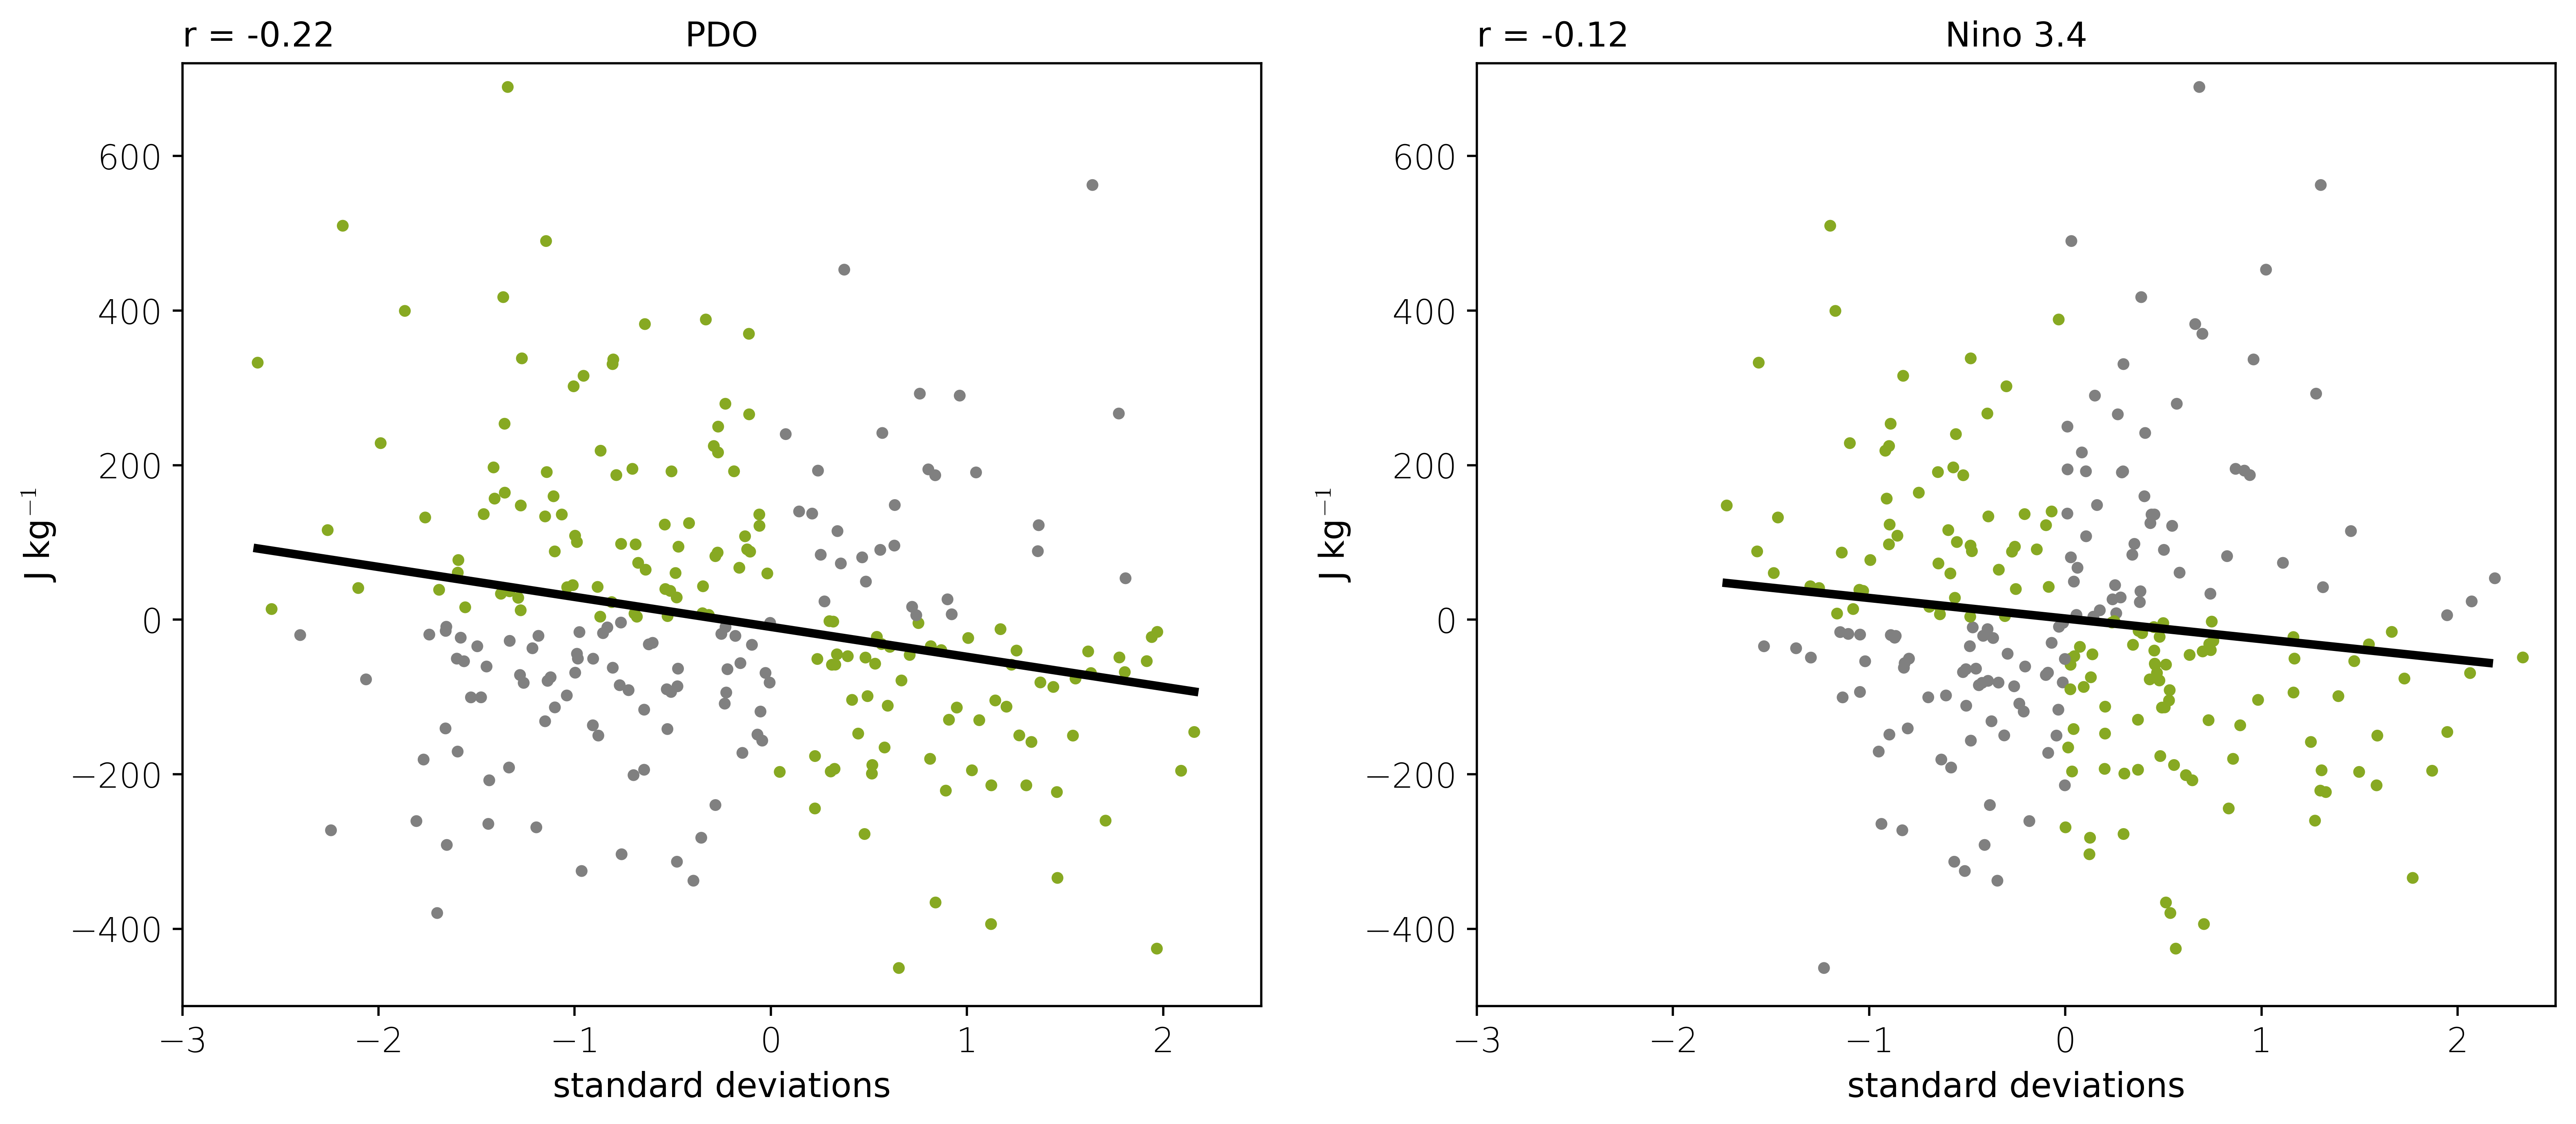

In [110]:
# Example: assign red if PDO > 1, blue if PDO < -1, gray otherwise
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

nino_colors = []
colors = []
for pdo_val, detrend_val in zip(pdo_1940_2024_mam, poly_detrend_no_climo_mean):
    if pdo_val > 0 and detrend_val < 0:
        colors.append('xkcd:avocado green')
    elif pdo_val < 0 and detrend_val > 0:
        colors.append('xkcd:avocado green')
    else:
        colors.append('gray')

for nino_val, detrend_nino_val in zip(nino_34_1940_2024_mam, poly_detrend_no_climo_mean):
    if nino_val > 0 and detrend_nino_val < 0:
        nino_colors.append('xkcd:avocado green')
    elif nino_val < 0 and detrend_nino_val > 0:
        nino_colors.append('xkcd:avocado green')
    else:
        nino_colors.append('gray')


ax[0].plot(x_fit, y, color='black', lw=3)
ax[0].scatter(pdo_1940_2024_mam, poly_detrend_no_climo_mean, c=colors, s=10)

ax[1].plot(x_fit_nino, y_nino, color='black', lw=3)
ax[1].scatter(nino_34_1940_2024_mam, poly_detrend_no_climo_mean, c=nino_colors, s=10)

ax[0].set_title('r = ' + str(round(cor, 2)), loc='left')
ax[1].set_title('r = ' + str(round(cor_nino, 2)), loc='left')

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

ax[0].set_ylabel('J kg$^{-1}$', fontsize=12)
ax[1].set_ylabel('J kg$^{-1}$', fontsize=12)
ax[0].set_xlabel('standard deviations', fontsize=12)
ax[1].set_xlabel('standard deviations', fontsize=12)

ax[0].set_ylim(-500, 720)
ax[1].set_ylim(-500, 720)
ax[0].set_xlim(-3, 2.5)
ax[1].set_xlim(-3, 2.5)

ax[0].set_title('PDO')
ax[1].set_title('Nino 3.4')